In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

from create_df_for_non_ipynb import create_dataframe
from path_util import data_path
from count_contributions import contributions_by_user, amount_detailed, avg_unique_auth_page_lengths
from viz_reg import robust_regression, multivariate_regression, simple_linear_regression, viz_sideways, relative_positive_negative, viz_gender_target
from sum_stats import sum_up_attributes
from reading_cpsaat import read_education_data, get_detailed_education, read_m2021, get_detailed_median_annual

# 1. CREATE DATAFRAME; PROCESSING

In [2]:
db_path = data_path / "data_bases" / "all_occupations.db"
con = sqlite3.connect(db_path)

df_all = pd.read_sql('SELECT occ_code, occ_group, occ_title, lenient_links, lenient_revs, lenient_lengths, women, white, african_american, asian, hispanic  FROM occupations', con)
df = df_all # make a copy

df = df.loc[df['women'] != "null"] # delete nulls

# fix parsing as float and rounding
for col in ["women", "white", "african_american", "asian", "hispanic"]:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: round(x, 3))

# add a column for non-hispanic white people
if "non_hispanic_white" not in df:
    df.insert(8, "non_hispanic_white", df["white"].subtract(df["hispanic"]))

# Naive assumption that 1-women == men
if "men" not in df:
    df.insert(6, "men", (df["women"] - 1).abs())
    
df_detailed = df # make copy
df_detailed = df_detailed.loc[df['occ_group'] == "detailed"] # has 453 rows (out of 831; so approx 55% of all detailed occs)

df_detailed = df_detailed.dropna() # after removing NaNs has 285 rows (so approx. 34.3% of all detailed)

articles_per_detailed = amount_detailed(df_all, df_detailed)
unique_auths, page_lengths, number_articles = avg_unique_auth_page_lengths(df_detailed)

if "art_per_detailed" not in df_detailed:
    df_detailed.insert(4, "art_per_detailed", articles_per_detailed)

if "avg_unique_auths" not in df_detailed:
    df_detailed.insert(6, "avg_unique_auths", unique_auths)
    
if "avg_art_lengths" not in df_detailed:
    df_detailed.insert(8, "avg_art_lengths", page_lengths)
    
if "amount_art" not in df_detailed:
    df_detailed.insert(4, "amount_art", number_articles)
    
df_detailed = df_detailed.loc[df_detailed['lenient_links'] != "[]"] # after this, only about 100 observations

df_merged = get_detailed_education(read_education_data(), df_detailed)


df_education = df_merged[['Less than high school diploma', 'High school diploma or equivalent', "Some college, no degree", 
                            "Associate's degree", "Bachelor's degree", "Master's degree", "Doctoral or professional degree"]]

if "education_slope" not in df_detailed:
    slopes = []
    nums = [i for i in range(1, 8)]
    for lst in df_education.values.tolist():
        slope, intercept, r_value, p_value, std_err = stats.linregress(nums, lst)
        slopes.append(slope)
    df_detailed['education_slope'] = slopes

    
if "A_MEAN" not in df_detailed:
    m_df = get_detailed_median_annual(read_m2021())
    df_detailed = df_detailed.set_index('occ_code').join(m_df.set_index('OCC_CODE'))
    df_detailed.reset_index(inplace=True) # make sure occ_code is a column and not the index

df_detailed = df_detailed.loc[df_detailed['A_MEAN'] != "*"] # can also interpolate (one observations)
    
df_detailed["A_MEAN"] = pd.to_numeric(df_detailed["A_MEAN"])
df_detailed["A_MEDIAN"] = pd.to_numeric(df_detailed["A_MEDIAN"])
df_detailed["education_slope"] = pd.to_numeric(df_detailed["education_slope"])

df_detailed.head(3)


,occ_code,occ_group,occ_title,lenient_links,amount_art,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_art_lengths,men,women,white,non_hispanic_white,african_american,asian,hispanic,education_slope,A_MEAN,A_MEDIAN
0,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...",1,0.026316,"{""Chief executive officer"": [{""revid"": 6437689...",1756.0,"{""Chief executive officer"": 17489}",17489.0,0.709,0.291,0.857,0.783,0.059,0.068,0.074,2.596429,213020,179520
1,11-1021,detailed,General and Operations Managers,"[[""General manager"", ""http://en.wikipedia.org/...",2,0.052632,"{""General manager"": [{""revid"": 749862417, ""use...",412.5,"{""General manager"": 7116, ""Operations manageme...",38205.5,0.636,0.364,0.827,0.724,0.093,0.046,0.103,-0.235714,115250,97970
2,11-2021,detailed,Marketing Managers,"[[""Marketing management"", ""http://en.wikipedia...",2,0.052632,"{""Marketing management"": [{""revid"": 837236871,...",354.5,"{""Marketing management"": 16750, ""Chief marketi...",12016.0,0.386,0.614,0.835,0.752,0.062,0.073,0.083,3.207143,153440,135030


### 1.2. EDA

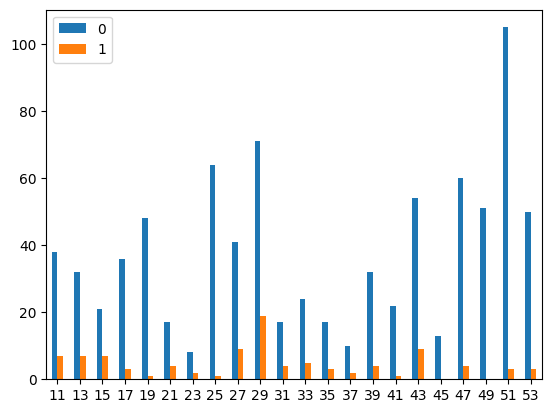

In [3]:
df_all_detailed = df_all.loc[df_all['occ_group'] == "detailed"] 

occ_dict = {}
for occ_code in df_all_detailed["occ_code"].tolist():
    beginning = int(str(occ_code)[0:2])
    if beginning not in occ_dict:
        occ_dict[beginning] = [1]  
    elif beginning in occ_dict:
        occ_dict[beginning][0] += 1

for occ_code in df_detailed["occ_code"].tolist():
    beginning = int(str(occ_code)[0:2])
    if len(occ_dict[beginning]) == 1:
        occ_dict[beginning].append(1)
    elif len(occ_dict[beginning]) == 2:
        occ_dict[beginning][1] += 1
    
for key, item in occ_dict.items(): # adjust for missing matches
    if len(item) == 1:
        occ_dict[key].append(0)
        
df_comp = pd.DataFrame(occ_dict).T
df_comparisons = df_comp.rename(index={0: "all", 1: "matched"})

_ = df_comparisons.plot(kind= 'bar' , secondary_y= 'matched', rot= 0 )
plt.show()

How well are the actual occupation represented by the gathered wiki articles?

# 2. ANALYSIS

### 2.1. Simple Linear Regression

Pearsons correlation is 0.706
The p-value is 4.845780386843807e-16


                            OLS Regression Results                            
Dep. Variable:               A_MEDIAN   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     95.28
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           4.85e-16
Time:                        14:58:42   Log-Likelihood:                -1117.0
No. Observations:                  98   AIC:                             2238.
Df Residuals:                      96   BIC:                             2243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

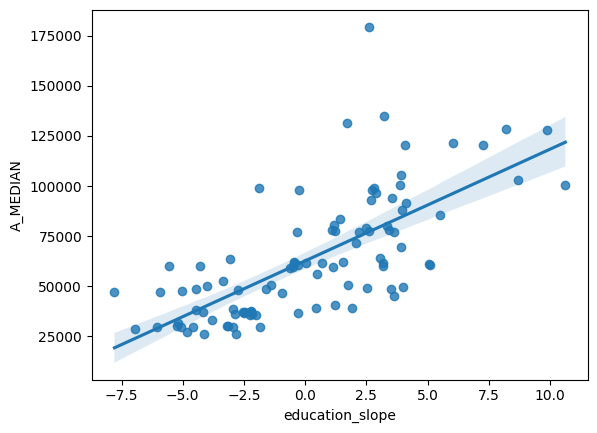

In [4]:
simple_linear_regression(df_detailed, "A_MEDIAN", "education_slope") # proof that education increases salary

Pearsons correlation is 0.085
The p-value is 0.4038529151603861


                            OLS Regression Results                            
Dep. Variable:        education_slope   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7030
Date:                Thu, 15 Sep 2022   Prob (F-statistic):              0.404
Time:                        15:06:40   Log-Likelihood:                -270.89
No. Observations:                  98   AIC:                             545.8
Df Residuals:                      96   BIC:                             551.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

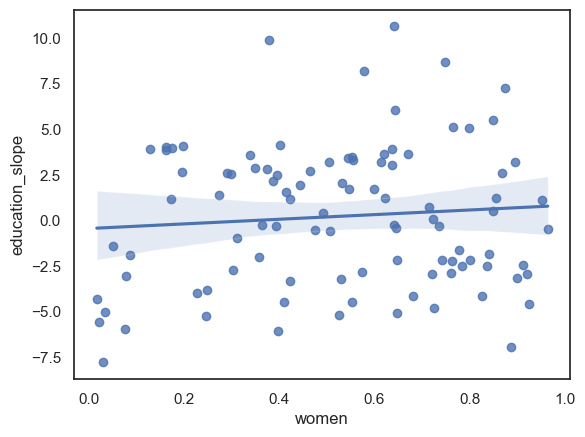

In [13]:
simple_linear_regression(df_detailed, "education_slope", "women") # first var is target

### 2.2. Multivariate Regression

                            OLS Regression Results                            
Dep. Variable:       avg_unique_auths   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     13.98
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           1.31e-07
Time:                        15:04:26   Log-Likelihood:                -733.39
No. Observations:                  98   AIC:                             1475.
Df Residuals:                      94   BIC:                             1485.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            887.0826    304

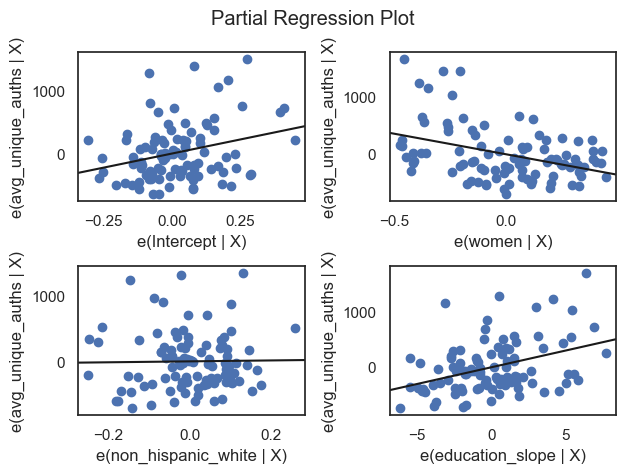

In [11]:
col_list = ["avg_unique_auths", "women", "non_hispanic_white", "education_slope"] # "african_american", 

multivariate_regression(df_detailed, col_list)

### 2.3. Robust Regression

Estimated coefficients (linear regression, RANSAC):
[5574.88401312] [6613.02674246]


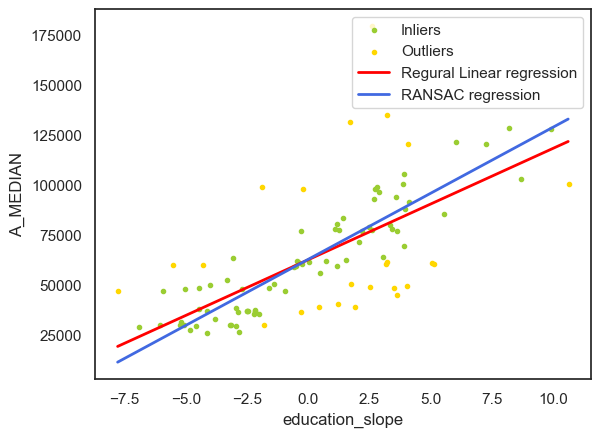

In [14]:
robust_regression(df_detailed, "A_MEDIAN", "education_slope") # first is target

### 2.4. Correlation Matrix

<AxesSubplot:>

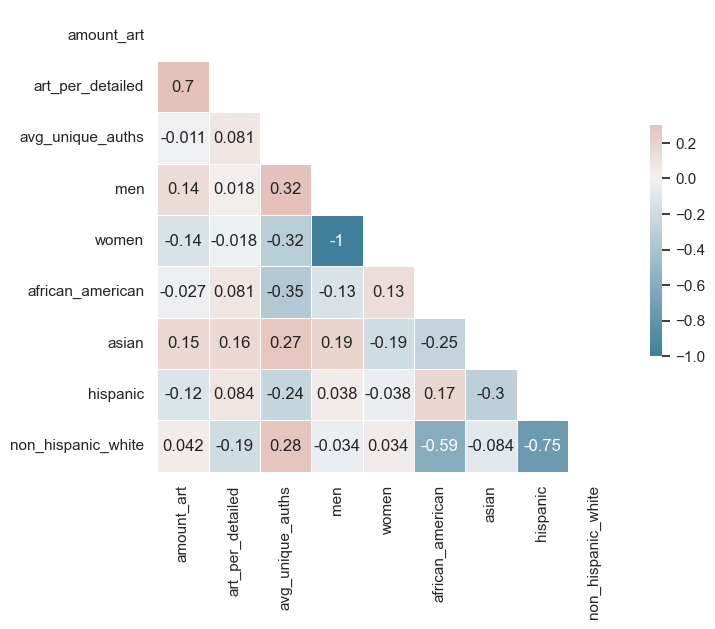

In [15]:
sns.set_theme(style="white")

corr_df = df_detailed[["amount_art", "art_per_detailed", "avg_unique_auths", 
                       "men", "women", "african_american", 
                       "asian", "hispanic", "non_hispanic_white"]].apply(pd.to_numeric)
corr_df.dropna(inplace = True)
corr = corr_df.corr(min_periods = 0)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})